In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zhiaun/river-floating-trash-datasets")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/river-floating-trash-datasets


In [2]:
!pip install -U torch torchvision
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-7x85kr0s
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-7x85kr0s
  Resolved https://github.com/facebookresearch/detectron2.git to commit 65184fc057d4fab080a98564f6b60fae0b94edc4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.9 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp311-cp311-linux_x86_64.whl size=6544032 sha256=26936472c3d2d92d9d667342948b4e82833fbf9442aed2bb1d1626eb4b78add2
  Stored in directory: /tmp/pip-ephem-wheel-cache-u89fownn/wheels/17/d9/40/60db98e485aa9455d

In [6]:
import torch
import os
import numpy as np
import json
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import DatasetMapper, build_detection_train_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [7]:
# Defining hyperparameters
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 32
EPOCHS = 10
NUM_CLASSES = 8
CLASS_NAMES = ['bottle', 'grass', 'branch', 'milk-box', 'plastic-bag', 'plastic-garbage', 'ball', 'leaf']

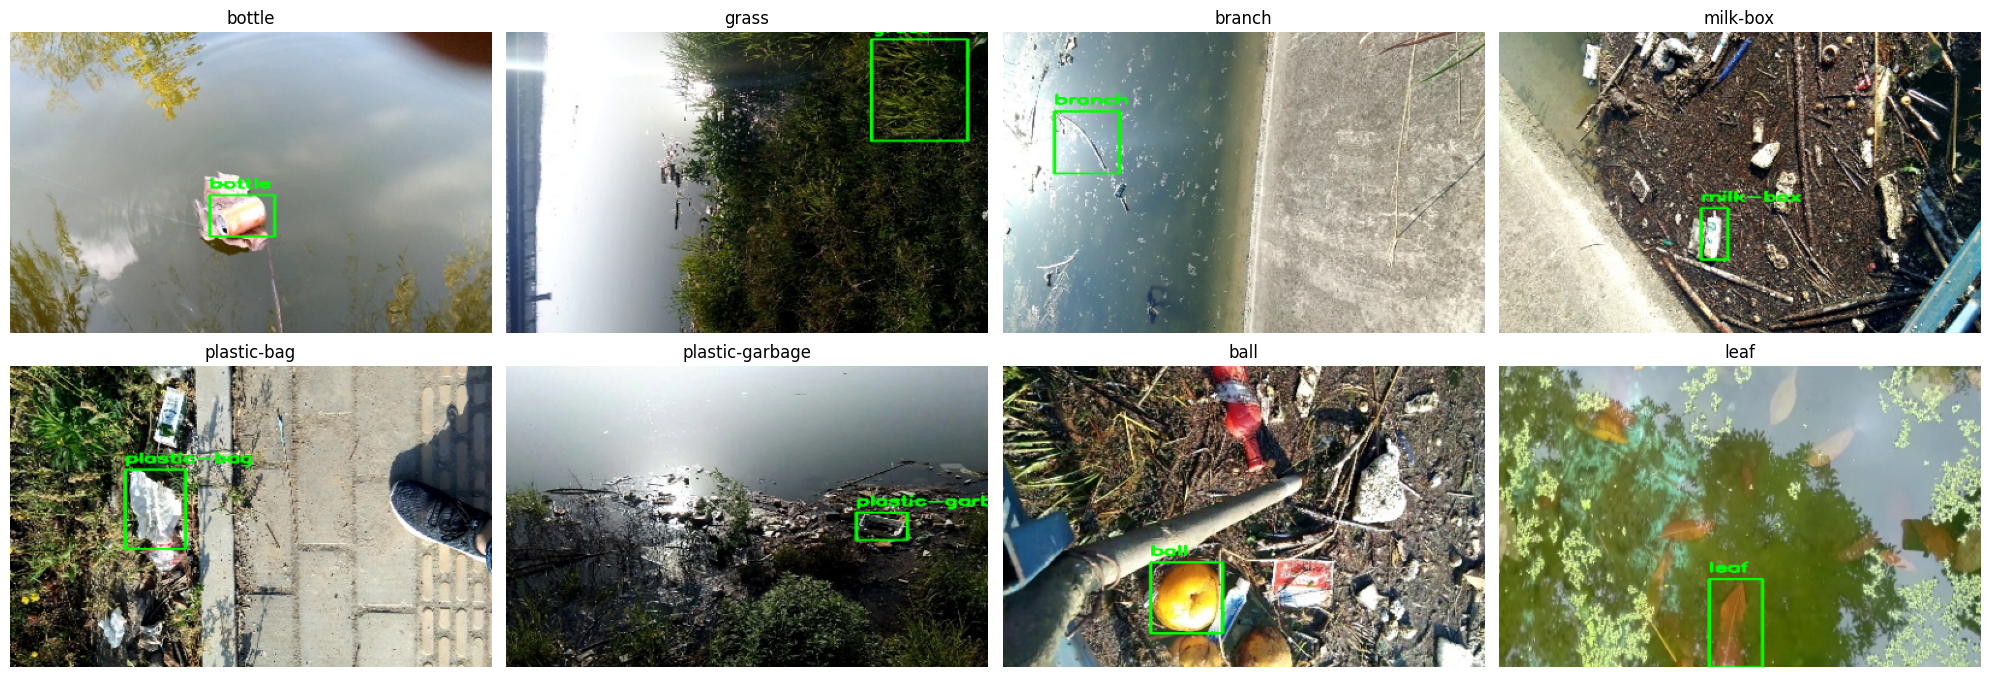

In [8]:
displayed_classes = set()

# To hold images and titles
images_to_display = []
titles = []

# Set image and label paths
image_dir = os.path.join(path, '/kaggle/input/river-floating-trash-datasets/datasets/RFT/images/train')
label_dir = os.path.join(path, '/kaggle/input/river-floating-trash-datasets/datasets/RFT/labels/train')

image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
image_files.sort()

# Loop through image files
for image_file in image_files:
    if len(displayed_classes) == len(CLASS_NAMES):
        break  

    img_path = os.path.join(image_dir, image_file)
    img = cv2.imread(img_path)
    if img is None:
        continue

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label_filename = os.path.splitext(image_file)[0] + '.txt'
    label_path = os.path.join(label_dir, label_filename)

    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
            img_height, img_width, _ = img_rgb.shape

            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id = int(parts[0])
                    class_name = CLASS_NAMES[class_id]

                    if class_name in displayed_classes:
                        continue

                    # Get bounding box coordinates
                    center_x, center_y, width, height = map(float, parts[1:])
                    x_center_abs = int(center_x * img_width)
                    y_center_abs = int(center_y * img_height)
                    width_abs = int(width * img_width)
                    height_abs = int(height * img_height)

                    x_min = int(x_center_abs - width_abs / 2)
                    y_min = int(y_center_abs - height_abs / 2)
                    x_max = int(x_center_abs + width_abs / 2)
                    y_max = int(y_center_abs + height_abs / 2)

                    # Draw bounding box and class name
                    color = (0, 255, 0)
                    cv2.rectangle(img_rgb, (x_min, y_min), (x_max, y_max), color, 2)
                    cv2.putText(img_rgb, class_name, (x_min, max(y_min - 10, 0)),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

                    # Resize for 2x4 grid display
                    img_resized = cv2.resize(img_rgb, (400, 250))

                    images_to_display.append(img_resized)
                    titles.append(class_name)
                    displayed_classes.add(class_name)
                    break

# Create 2x4 subplot
fig, axes = plt.subplots(2, 4, figsize=(20, 7))

for ax, img, title in zip(axes.flatten(), images_to_display, titles):
    ax.imshow(img)
    ax.set_title(title, fontsize=12)
    ax.axis('off')

# Hide empty subplots if any
for i in range(len(images_to_display), 8):
    axes.flatten()[i].axis('off')

plt.tight_layout()
plt.show()


In [13]:
#converting yolo formatted dataset to coco format(Both train and test)

import os
import json
from PIL import Image

def yolo_to_coco(yolo_dir, image_dir, output_json_path, class_names, image_size=(416, 416)):
    coco_output = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    annotation_id = 1
    image_id = 1

    # Add categories
    for idx, class_name in enumerate(class_names):
        coco_output["categories"].append({
            "id": idx + 1,
            "name": class_name
        })

    for filename in os.listdir(yolo_dir):
        if not filename.endswith(".txt"):
            continue

        txt_path = os.path.join(yolo_dir, filename)
        img_filename = filename.replace(".txt", ".jpg")
        img_path = os.path.join(image_dir, img_filename)

        if not os.path.exists(img_path):
            continue

        # Use real image size (if not fixed 416x416)
        with Image.open(img_path) as img:
            width, height = img.size

        # Add image metadata
        coco_output["images"].append({
            "id": image_id,
            "file_name": img_filename,
            "width": width,
            "height": height
        })

        with open(txt_path, "r") as f:
            for line in f:
                cls_id, x, y, w, h = map(float, line.strip().split())
                x_min = (x - w / 2) * width
                y_min = (y - h / 2) * height
                box_width = w * width
                box_height = h * height

                coco_output["annotations"].append({
                    "id": annotation_id,
                    "image_id": image_id,
                    "category_id": int(cls_id) + 1,
                    "bbox": [x_min, y_min, box_width, box_height],
                    "area": box_width * box_height,
                    "iscrowd": 0
                })

                annotation_id += 1

        image_id += 1

    with open(output_json_path, "w") as f:
        json.dump(coco_output, f, indent=4)

# Example usage
class_names = ['bottle', 'grass', 'branch', 'milk-box', 'plastic-bag', 'plastic-garbage', 'ball', 'leaf']
yolo_to_coco(
    yolo_dir="/kaggle/input/river-floating-trash-datasets/datasets/RFT/labels/train",
    image_dir="/kaggle/input/river-floating-trash-datasets/datasets/RFT/images/train",
    output_json_path="/content/train_coco_annotations.json",
    class_names=class_names
)


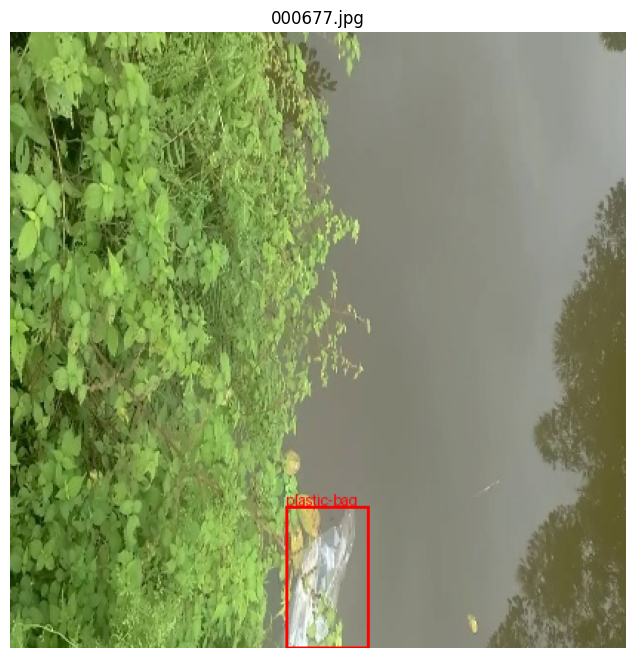

In [15]:
import json
import os
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Load COCO annotations
with open('/content/train_coco_annotations.json', 'r') as f:
    coco = json.load(f)

# Map image_id to image file name
image_id_to_file = {img['id']: img['file_name'] for img in coco['images']}

# Map category_id to category name
category_id_to_name = {cat['id']: cat['name'] for cat in coco['categories']}

# Select the first image and its annotations
first_image_id = coco['images'][0]['id']
first_image_filename = image_id_to_file[first_image_id]
annotations = [ann for ann in coco['annotations'] if ann['image_id'] == first_image_id]

# Load and display image
image_path = f"/kaggle/input/river-floating-trash-datasets/datasets/RFT/images/train/{first_image_filename}"
image = Image.open(image_path).convert("RGB")
draw = ImageDraw.Draw(image)

# Optional: Load font
try:
    font = ImageFont.truetype("arial.ttf", 16)
except:
    font = ImageFont.load_default()

# Draw bounding boxes
for ann in annotations:
    bbox = ann['bbox']  # [x, y, width, height]
    category_name = category_id_to_name[ann['category_id']]
    x, y, w, h = bbox
    draw.rectangle([x, y, x + w, y + h], outline="red", width=2)
    draw.text((x, y - 10), category_name, fill="red", font=font)

# Show image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.title(first_image_filename)
plt.show()


In [16]:
register_coco_instances("my_dataset_train", {}, "/content/train_coco_annotations.json", "/kaggle/input/river-floating-trash-datasets/datasets/RFT/images/train")
register_coco_instances("my_dataset_test", {}, "//content/test_coco_annotations.json", "/kaggle/input/river-floating-trash-datasets/datasets/RFT/images/test")

In [18]:
import json

# Load COCO JSON file
with open('/content/train_coco_annotations.json') as f:
    coco_json = json.load(f)

# Get number of classes
num_classes = len(coco_json["categories"])

# Set in config
cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes


In [19]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_test",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128

# Load COCO annotations to get number of classes
with open('/content/train_coco_annotations.json') as f:
    coco_json = json.load(f)

cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(coco_json["categories"])


In [20]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/28 12:16:21 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:01, 141MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[05/28 12:16:22 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/28 12:16:32 d2.utils.events]:  eta: 0:47:14  iter: 19  total_loss: 2.79  loss_cls: 2.246  loss_box_reg: 0.4573  loss_rpn_cls: 0.02194  loss_rpn_loc: 0.007522    time: 0.2885  last_time: 0.3148  data_time: 0.0128  last_data_time: 0.0114   lr: 4.9953e-06  max_mem: 1737M
[05/28 12:16:44 d2.utils.events]:  eta: 0:46:49  iter: 39  total_loss: 2.7  loss_cls: 2.124  loss_box_reg: 0.4897  loss_rpn_cls: 0.04496  loss_rpn_loc: 0.00997    time: 0.2866  last_time: 0.2802  data_time: 0.0080  last_data_time: 0.0057   lr: 9.9902e-06  max_mem: 1737M
[05/28 12:16:50 d2.utils.events]:  eta: 0:47:21  iter: 59  total_loss: 2.192  loss_cls: 1.745  loss_box_reg: 0.4017  loss_rpn_cls: 0.02355  loss_rpn_loc: 0.007185    time: 0.2891  last_time: 0.3140  data_time: 0.0069  last_data_time: 0.0056   lr: 1.4985e-05  max_mem: 1737M
[05/28 12:16:56 d2.utils.events]:  eta: 0:48:19  iter: 79  total_loss: 1.877  loss_cls: 1.33  loss_box_reg: 0.4228  loss_rpn_cls: 0.03177  loss_rpn_loc: 0.005906    time: 0.2920  las

In [31]:
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
print(inference_on_dataset(trainer.model, val_loader, evaluator))


WARNING [05/28 13:25:40 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/28 13:25:40 d2.data.datasets.coco]: Loaded 481 images in COCO format from //content/test_coco_annotations.json
[05/28 13:25:40 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/28 13:25:40 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/28 13:25:40 d2.data.common]: Serializing 481 elements to byte tensors and concatenating them all ...
[05/28 13:25:40 d2.data.common]: Serialized dataset takes 0.15 MiB
[05/28 13:25:40 d2.evaluation.evaluator]: Start inference on 481 batches
[05/28 13:25:41 d2.evaluation.evaluator]: Inference done 11/481. Dataloading: 0.0037 s/iter. Inference: 0.0786 s/iter. Eval: 0.0003 s/iter. Total: 0.0827 s/iter. ETA=0:00:38

In [23]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

[05/28 13:11:16 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [24]:
im = cv2.imread("/kaggle/input/river-floating-trash-datasets/datasets/RFT/images/val/000058.jpg")

In [25]:
outputs = predictor(im)

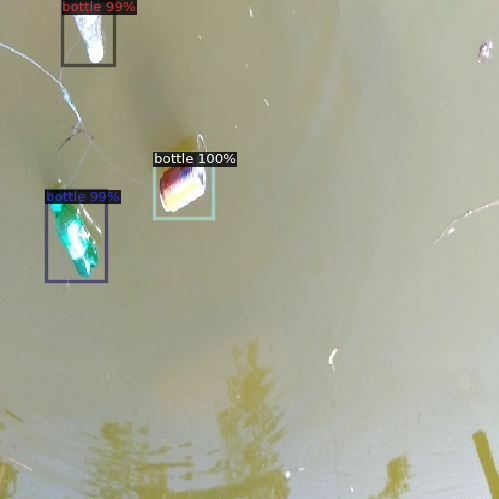

In [28]:
# Visualize predictions
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Display the image
cv2_imshow(v.get_image()[:, :, ::-1])


In [29]:
cv2.imwrite("detected_image.jpg", v.get_image()[:, :, ::-1])

True

In [30]:
torch.save(trainer.model.state_dict(), "/content/drive/MyDrive/RFT_model.pth")